<a href="https://colab.research.google.com/github/Raj-Vaghela/Patient-Readmission-Prediction-Google-Colab/blob/main/BDPA_CW_Part_2_Improved_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, normaltest

In [404]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [405]:
df = pd.read_csv('/content/drive/My Drive/Raj Vaghela/diabetic_data.csv', na_values='?' , low_memory=False)

In [406]:
print(df.describe())
print('\nshape of original data:',df.shape)

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

In [407]:
for column in df.columns:
    value_counts = df[column].value_counts() # Calculate value counts for the current column
    total_count = len(df) # Calculate total count for the column

    max_value = value_counts.idxmax()
    max_count = value_counts.max()
    max_percentage = (max_count / total_count) * 100

    unique_values_count = df[column].nunique()  # Count number of unique values in the column

    print(f"Column: {column}")
    print(f"Value: {max_value}, Percentage Occurrence: {max_percentage:.2f}%, Occurance Count: {max_count}, Number of Unique Values: {unique_values_count}\n")


Column: encounter_id
Value: 2278392, Percentage Occurrence: 0.00%, Occurance Count: 1, Number of Unique Values: 101766

Column: patient_nbr
Value: 88785891, Percentage Occurrence: 0.04%, Occurance Count: 40, Number of Unique Values: 71518

Column: race
Value: Caucasian, Percentage Occurrence: 74.78%, Occurance Count: 76099, Number of Unique Values: 5

Column: gender
Value: Female, Percentage Occurrence: 53.76%, Occurance Count: 54708, Number of Unique Values: 3

Column: age
Value: [70-80), Percentage Occurrence: 25.62%, Occurance Count: 26068, Number of Unique Values: 10

Column: weight
Value: [75-100), Percentage Occurrence: 1.31%, Occurance Count: 1336, Number of Unique Values: 9

Column: admission_type_id
Value: 1, Percentage Occurrence: 53.05%, Occurance Count: 53990, Number of Unique Values: 8

Column: discharge_disposition_id
Value: 1, Percentage Occurrence: 59.19%, Occurance Count: 60234, Number of Unique Values: 26

Column: admission_source_id
Value: 7, Percentage Occurrence: 5

In [408]:
df['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [409]:
value_to_check = 'Unknown/Invalid' #checking since it occured in previous step that there is third value in gender column
occurrences = df['gender'].value_counts().get(value_to_check, 0)
print(f"The value '{value_to_check}' occurs {occurrences} times in the column 'gender'.")


The value 'Unknown/Invalid' occurs 3 times in the column 'gender'.


In [410]:
#left gender col as is because there are only 3 in 100000+ rows haveing this value so it wont compromise the model
df['readmitted'] = df['readmitted'].replace({'<30':1, '>30':0, 'NO':0}, )
unique_values = df['readmitted'].unique()
print(unique_values)

[0 1]


In [411]:
df.shape

(101766, 50)

In [412]:
missingValues = df.isnull().sum()
missingValues = missingValues[missingValues>0]
missingPercentage = (missingValues/len(df))*100

missingInfo = pd.DataFrame({'Missing Values': missingValues, 'Missing Percentage': missingPercentage})
print(missingInfo)
print('\nShape ',df.shape)

                   Missing Values  Missing Percentage
race                         2273            2.233555
weight                      98569           96.858479
payer_code                  40256           39.557416
medical_specialty           49949           49.082208
diag_1                         21            0.020636
diag_2                        358            0.351787
diag_3                       1423            1.398306

Shape  (101766, 50)


In [413]:
#deleting cols with a lot of uniques values or a lot of missing values and this many missing values cannot be filled
cols_to_delete = ['encounter_id', 'patient_nbr', 'weight' ]
df = df.drop(columns=cols_to_delete)
df.shape

(101766, 47)

In [414]:
missingValues = df.isnull().sum()
missingValues = missingValues[missingValues>0]
cols_with_missing = missingValues.index.tolist()

df[cols_with_missing] = df[cols_with_missing].fillna(method='bfill')
df[cols_with_missing] = df[cols_with_missing].fillna(method='ffill')

missing_values_after_fill = df.isnull().sum()
missing_values_after_fill = missing_values_after_fill[missing_values_after_fill > 0]


print("\nMissing values after backward fill:")
print(missing_values_after_fill)

print('\nShape:', df.shape)



Missing values after backward fill:
Series([], dtype: int64)

Shape: (101766, 47)


In [415]:
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
missing_values = df.isnull().sum()
missing_values_summary = missing_values[missing_values > 0]
print("Summary of missing values in each column:")
print(missing_values_summary)

Summary of missing values in each column:
Series([], dtype: int64)


In [416]:
for feature in df.columns:
    if df[feature].nunique() < 5:
        print(str(feature)+ ":"+ str(df[feature].nunique()))

gender:3
max_glu_serum:4
A1Cresult:4
metformin:4
repaglinide:4
nateglinide:4
chlorpropamide:4
glimepiride:4
acetohexamide:2
glipizide:4
glyburide:4
tolbutamide:2
pioglitazone:4
rosiglitazone:4
acarbose:4
miglitol:4
troglitazone:2
tolazamide:3
examide:1
citoglipton:1
insulin:4
glyburide-metformin:4
glipizide-metformin:2
glimepiride-pioglitazone:2
metformin-rosiglitazone:2
metformin-pioglitazone:2
change:2
diabetesMed:2
readmitted:2


In [417]:
column_to_delete = ['examide', 'citoglipton']  # delete the column with only one unique number
df = df.drop(columns=column_to_delete)


In [418]:
df.shape

(101766, 45)

In [419]:
for column in df:
        value_counts = df[column].value_counts() # Calculate value counts for the current column
        total_count = len(df) # Calculate total count for the column

        max_value = value_counts.idxmax()
        max_count = value_counts.max()
        max_percentage = (max_count / total_count) * 100

        print(f"Column: {column}")
        print(f"Value: {max_value}, Percentage Occurrence: {max_percentage:.2f}%, Count: {max_count}\n")

Column: race
Value: Caucasian, Percentage Occurrence: 76.47%, Count: 77819

Column: gender
Value: Female, Percentage Occurrence: 53.76%, Count: 54708

Column: age
Value: [70-80), Percentage Occurrence: 25.62%, Count: 26068

Column: admission_type_id
Value: 1, Percentage Occurrence: 53.05%, Count: 53990

Column: discharge_disposition_id
Value: 1, Percentage Occurrence: 59.19%, Count: 60234

Column: admission_source_id
Value: 7, Percentage Occurrence: 56.50%, Count: 57494

Column: time_in_hospital
Value: 3, Percentage Occurrence: 17.45%, Count: 17756

Column: payer_code
Value: MC, Percentage Occurrence: 63.86%, Count: 64990

Column: medical_specialty
Value: InternalMedicine, Percentage Occurrence: 26.19%, Count: 26655

Column: num_lab_procedures
Value: 1, Percentage Occurrence: 3.15%, Count: 3208

Column: num_procedures
Value: 0, Percentage Occurrence: 45.84%, Count: 46652

Column: num_medications
Value: 13, Percentage Occurrence: 5.98%, Count: 6086

Column: number_outpatient
Value: 0, P

In [420]:
cols_deleted = []  # List to store the names of deleted columns

for column in df.columns:
    value_counts = df[column].value_counts()
    total_count = len(df)

    max_percentage = (value_counts.max() / total_count) * 100

    if max_percentage > 98:
        cols_deleted.append(column)
        df = df.drop(columns=[column])

# Print the names of columns deleted
print("Columns deleted due to max percentage occurrence over 98%:")
for col in cols_deleted:
    print(col)


Columns deleted due to max percentage occurrence over 98%:
repaglinide
nateglinide
chlorpropamide
acetohexamide
tolbutamide
acarbose
miglitol
troglitazone
tolazamide
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone


In [421]:
#coincidentally deleted the same cols which were mentioned in the part-1 but this time with reason
df.shape

(101766, 31)

In [422]:
def identify_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

df_no_outliers = df.copy()

for column in df_no_outliers.select_dtypes(include=['int64', 'float64']).columns:
    if column not in ['readmitted','number_outpatient','number_emergency','number_inpatient','admission_type_id','discharge_disposition_id','admission_source_id']: #since all these numbers have very long tails and IDs are categorical data
        outliers = identify_outliers_iqr(df_no_outliers[column])
        num_outliers = outliers.sum()
        df_no_outliers = df_no_outliers.loc[~outliers]
        print(f"Total outliers in '{column}': {num_outliers}")
        print(f"-outliers from '{column}' gave shape {df_no_outliers.shape}")

Total outliers in 'time_in_hospital': 2252
-outliers from 'time_in_hospital' gave shape (99514, 31)
Total outliers in 'num_lab_procedures': 118
-outliers from 'num_lab_procedures' gave shape (99396, 31)
Total outliers in 'num_procedures': 4644
-outliers from 'num_procedures' gave shape (94752, 31)
Total outliers in 'num_medications': 2392
-outliers from 'num_medications' gave shape (92360, 31)
Total outliers in 'number_diagnoses': 268
-outliers from 'number_diagnoses' gave shape (92092, 31)


In [423]:
df_no_outliers.dtypes

race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
glimepiride                 object
glipizide                   object
glyburide                   object
pioglitazone                object
rosiglitazone               object
insulin                     object
change              

In [424]:
col_to_normalize = ['number_inpatient','number_emergency','number_outpatient','num_medications','num_procedures','num_lab_procedures','time_in_hospital','number_diagnoses']

def min_max_scaling(x):
    return (x - x.min()) / (x.max() - x.min())

df_no_outliers[col_to_normalize] = df_no_outliers[col_to_normalize].apply(min_max_scaling)
print(df_no_outliers)

                   race  gender      age  admission_type_id  \
1             Caucasian  Female  [10-20)                  1   
2       AfricanAmerican  Female  [20-30)                  1   
3             Caucasian    Male  [30-40)                  1   
4             Caucasian    Male  [40-50)                  1   
6             Caucasian    Male  [60-70)                  3   
...                 ...     ...      ...                ...   
101761  AfricanAmerican    Male  [70-80)                  1   
101762  AfricanAmerican  Female  [80-90)                  1   
101763        Caucasian    Male  [70-80)                  1   
101764        Caucasian  Female  [80-90)                  2   
101765        Caucasian    Male  [70-80)                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
1                              1                    7          0.181818   
2                              1                    7          0.090909   
3                 

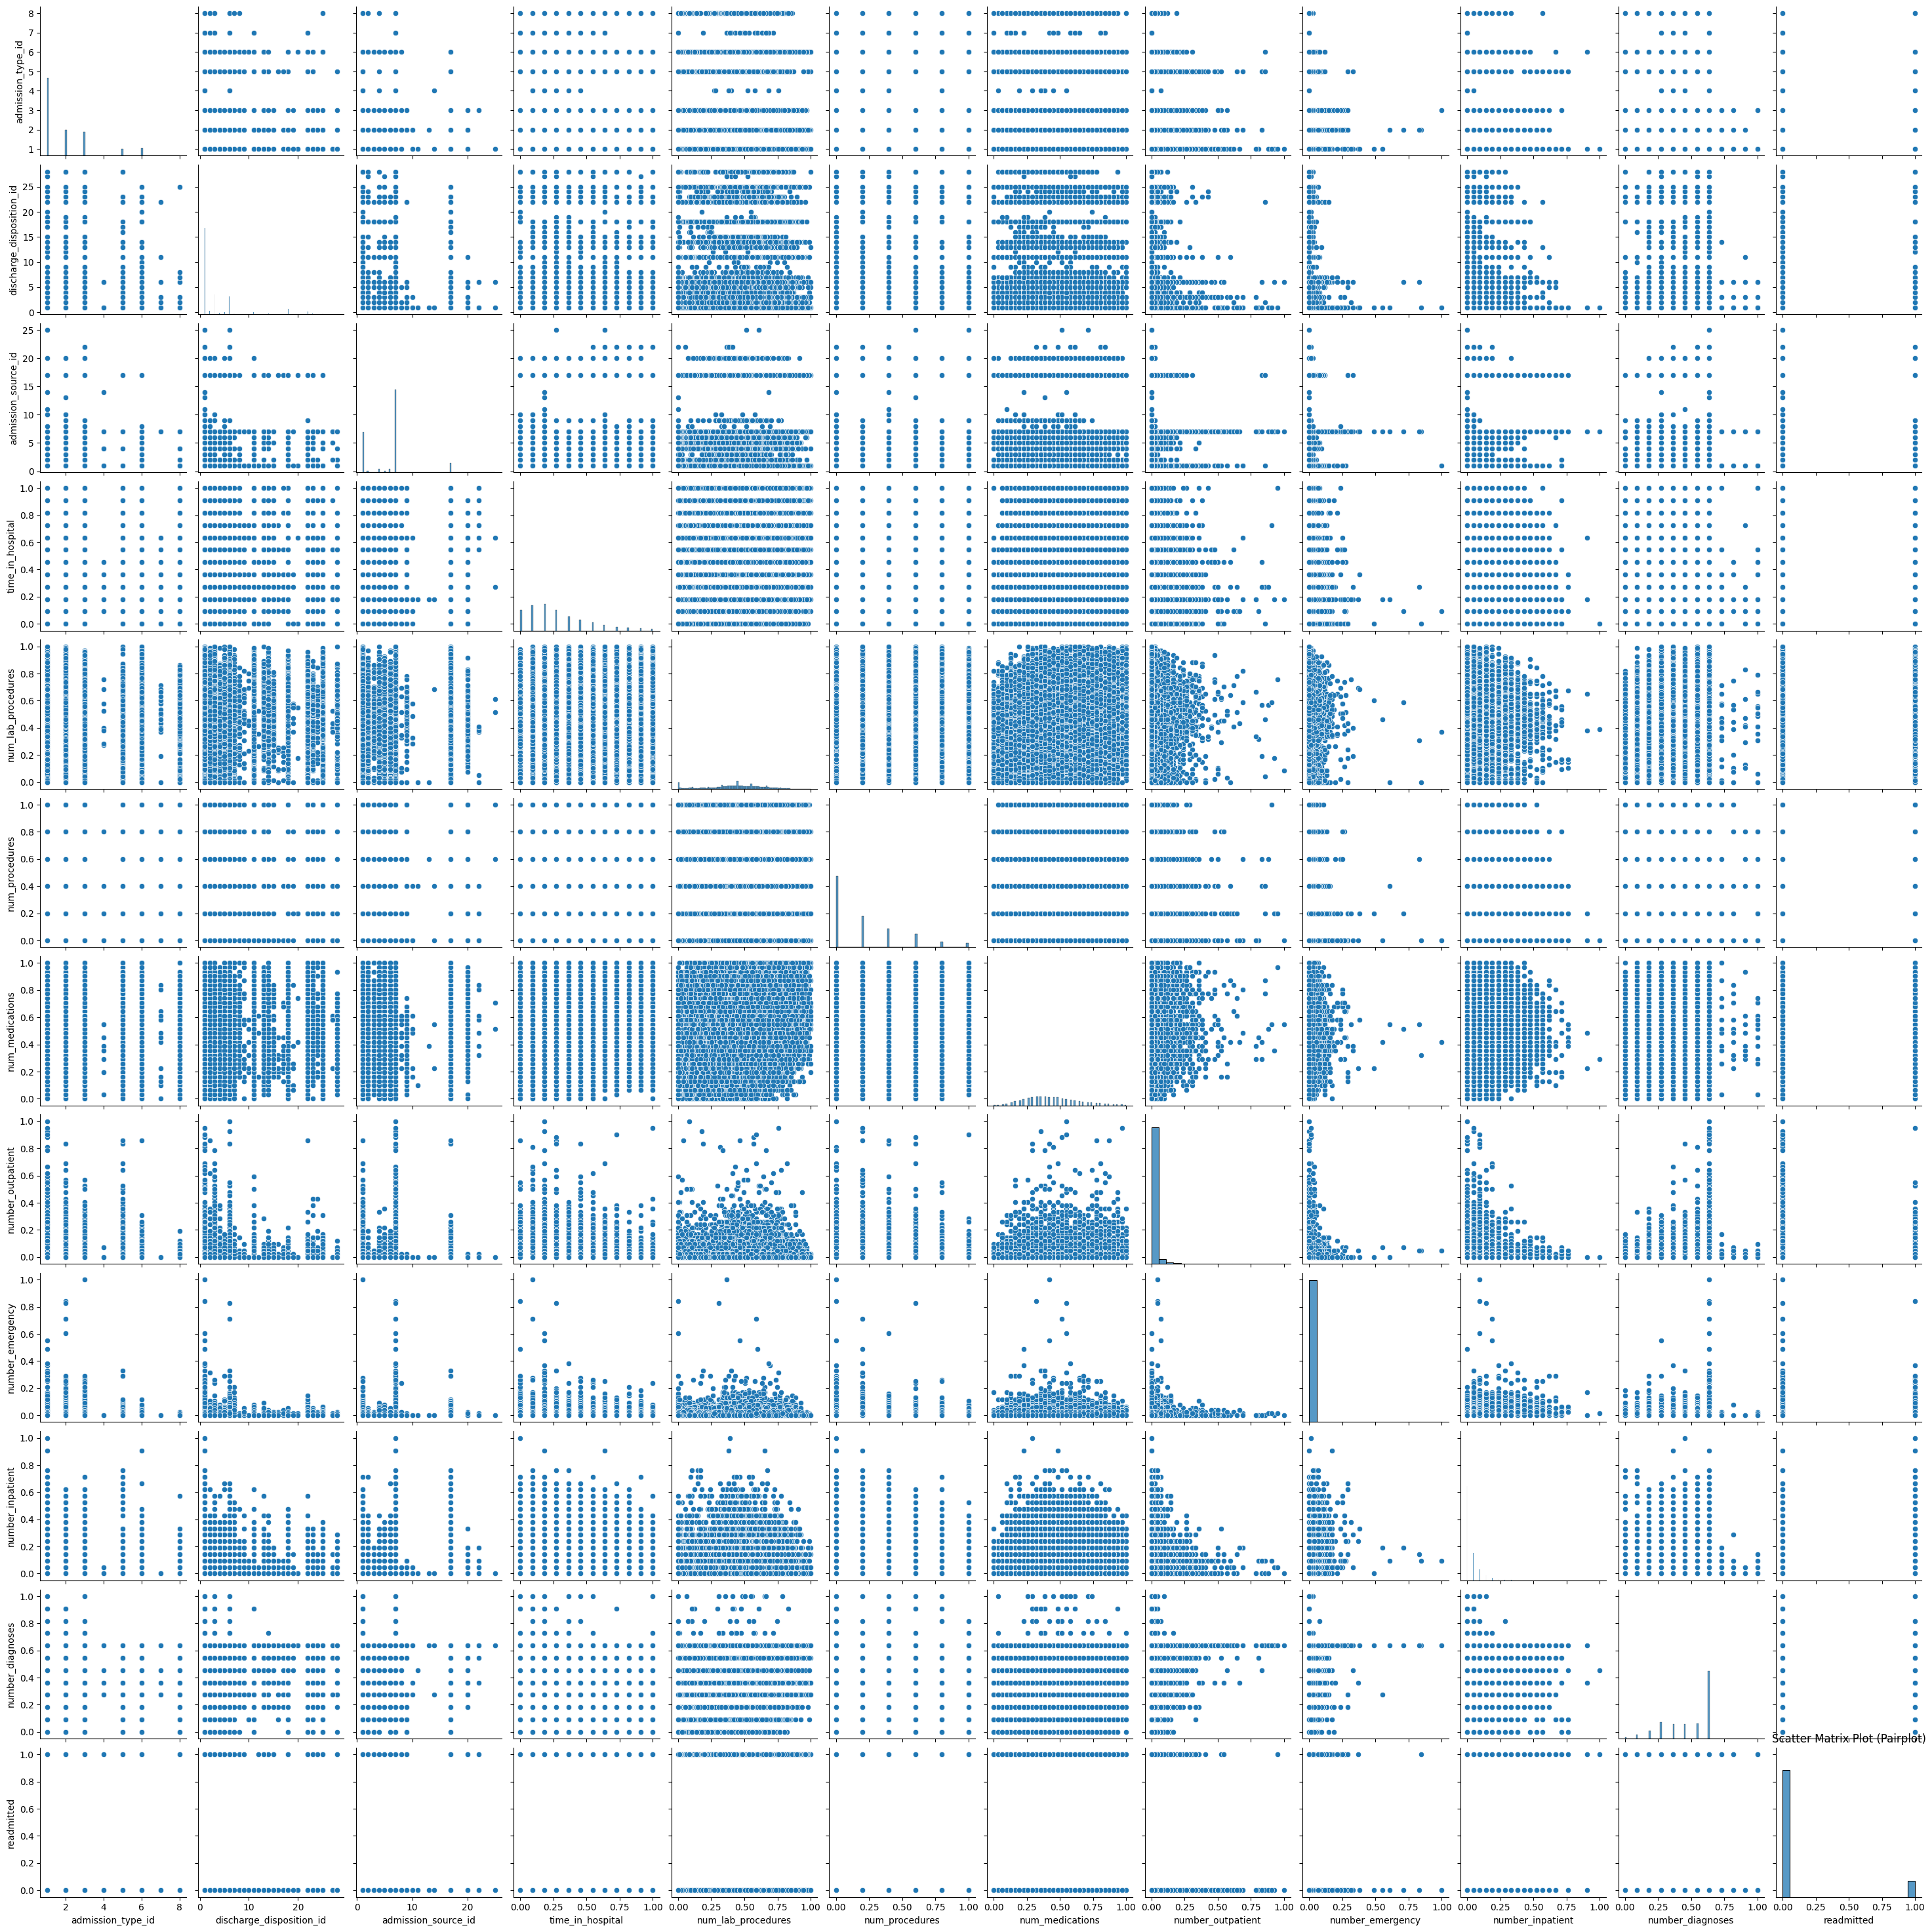

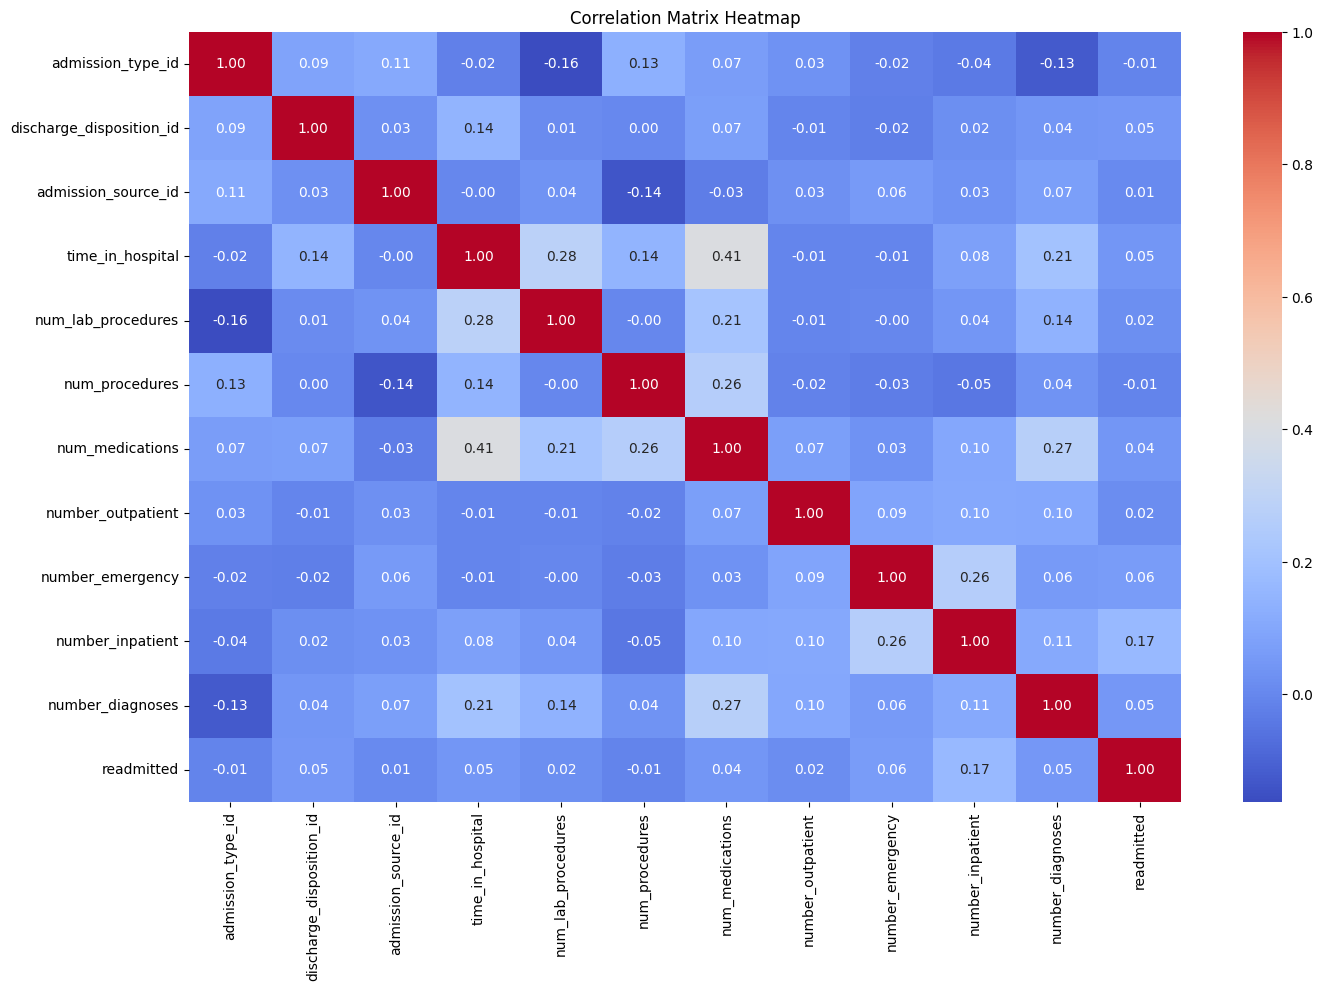

In [425]:
import seaborn as sns
sns.pairplot(df_no_outliers)
plt.title('Scatter Matrix Plot (Pairplot)')
plt.show()

correlation_matrix = df_no_outliers.corr(numeric_only=True)

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [426]:
col_to_normalize = ['number_inpatient','num_medications','num_procedures','num_lab_procedures','time_in_hospital','number_diagnoses','number_outpatient','number_emergency']

def min_max_scaling(x):
    return (x - x.min()) / (x.max() - x.min())
df_no_outliers[col_to_normalize] = df_no_outliers[col_to_normalize].apply(min_max_scaling)

# print(df_no_outliers.head(10))
from IPython.display import display
display(df_no_outliers.head(10))

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,0.181818,MC,InternalMedicine,0.610526,...,No,No,No,No,No,No,Up,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,0.090909,MC,InternalMedicine,0.105263,...,No,No,Steady,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,0.090909,MC,InternalMedicine,0.452632,...,No,No,No,No,No,No,Up,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,0.000000,MC,InternalMedicine,0.526316,...,No,No,Steady,No,No,No,Steady,Ch,Yes,0
6,Caucasian,Male,[60-70),3,1,2,0.272727,MC,InternalMedicine,0.726316,...,Steady,Steady,No,No,No,No,Steady,Ch,Yes,0
7,Caucasian,Male,[70-80),1,1,7,0.363636,MC,InternalMedicine,0.757895,...,No,No,No,Steady,No,No,No,No,Yes,0
9,Caucasian,Female,[90-100),3,3,4,1.000000,MC,InternalMedicine,0.336842,...,No,No,No,No,No,Steady,Steady,Ch,Yes,0
10,AfricanAmerican,Female,[40-50),1,1,7,0.727273,MC,Family/GeneralPractice,0.484211,...,No,No,No,No,No,No,Steady,No,Yes,0
11,AfricanAmerican,Male,[60-70),2,1,4,0.545455,MC,Family/GeneralPractice,0.642105,...,No,No,No,Up,No,No,Steady,Ch,Yes,1
12,Caucasian,Female,[40-50),1,3,7,0.545455,MC,Family/GeneralPractice,0.621053,...,Steady,No,No,No,No,No,Down,Ch,Yes,1


In [427]:
categorical_cols_forLabelEncoding = ['A1Cresult','max_glu_serum','age']
categorical_cols_forOneHotEncoding = ['medical_specialty','payer_code','admission_type_id','discharge_disposition_id','admission_source_id',
                                      'race','gender','diag_1','diag_2','diag_3','change','insulin','rosiglitazone','pioglitazone','glyburide','glipizide','metformin','diabetesMed']
# Label encoding
for feature in categorical_cols_forLabelEncoding:
    df_no_outliers[feature] = pd.factorize(df_no_outliers[feature])[0]

# One-hot encoding
df_no_outliers = pd.get_dummies(df_no_outliers, columns=categorical_cols_forOneHotEncoding, drop_first=True)


print('After Encoding shape :',df_no_outliers.shape)

After Encoding shape : (92092, 2403)


In [428]:
cols_without_specified_dtype = [col for col in df_no_outliers.columns if df_no_outliers[col].dtype not in ['int64', 'float64', 'uint8']]

# Print the columns
print("Columns without 'int64', 'float64', or 'uint8' data types:")
if len(cols_without_specified_dtype) > 0:
    for col in cols_without_specified_dtype:
        print(col)
else:
    print("None as all columns have 'int64', 'float64', or 'uint8' data types.")

Columns without 'int64', 'float64', or 'uint8' data types:
glimepiride


Model Building


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

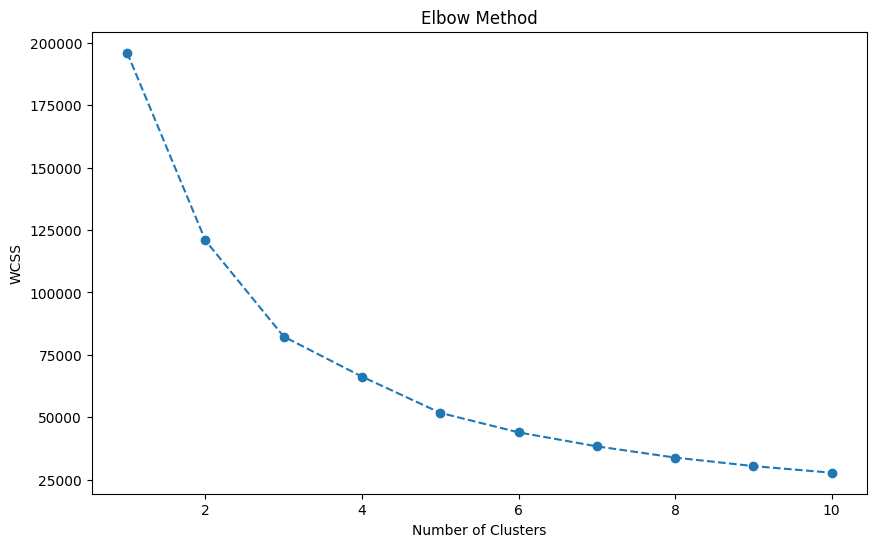

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


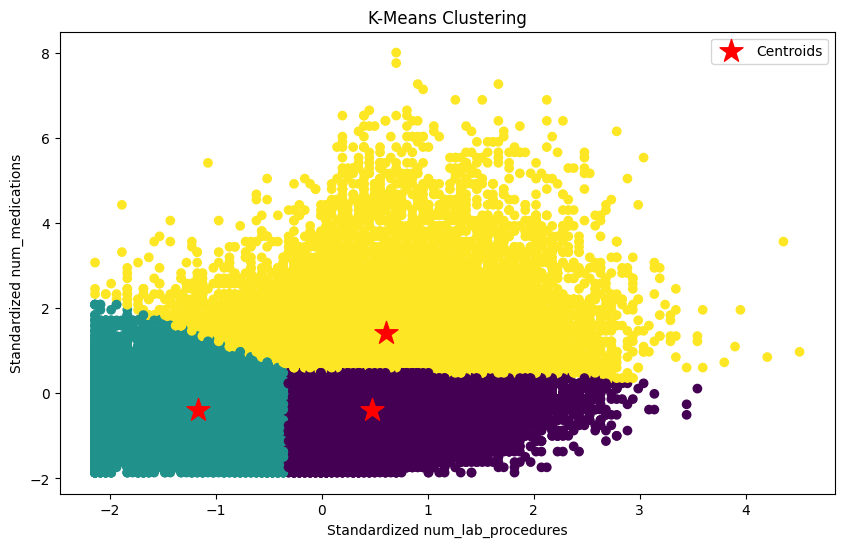

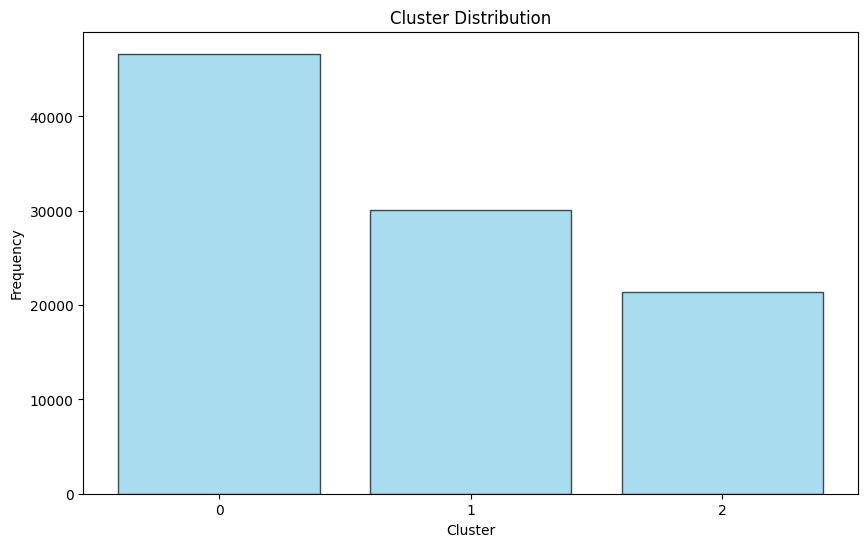

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load your cleansed dataset
# Assume df_cleaned is your cleansed DataFrame

# Select relevant features for clustering
# Example: For this demonstration, let's select 'num_lab_procedures' and 'num_medications'
X = df_cleaned[['num_lab_procedures', 'num_medications']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

# Based on the elbow method, determine the optimal number of clusters
# Example: Let's assume 3 clusters as the optimal number

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Assign cluster labels to the data
df_cleaned['cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='*', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Standardized num_lab_procedures')
plt.ylabel('Standardized num_medications')
plt.legend()
plt.show()

# Analyze cluster distribution compared to the original data
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['cluster'], bins=np.arange(4)-0.5, rwidth=0.8, color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks(range(3))
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()
